In [1]:
#...............import necessary library and module
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


In [2]:
#........................preprocessing............................................


#.......extract images from video(by harcascade).............


def extract_video(video,root_save_image):
     
    capture = cv2.VideoCapture(video)
    #print(capture)
    frames_num = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    #print(frames_num)

   
    for i in range(frames_num):
        capture.grab()
        #if i % 5 != 0:
            #continue
        success, frame = capture.retrieve()
         
        if not success:
            continue
        id = os.path.splitext(os.path.basename(video))[0]
         
        #print(frame)
        #print(id)
        #create haar cascade
        image_copy = np.copy(frame)
        cascade=cv2.CascadeClassifier('E:/python/haarcascade_frontalface_default.XML')
        
        faces=cascade.detectMultiScale(
                          frame,
                          scaleFactor=1.3,
                          minSize=(30,30),
                          flags=cv2.CASCADE_SCALE_IMAGE
                           )
        #draw a rectangle
        #face_crop = []
        #print(len(faces))
        if len(faces)>0:
             
            for (x,y,w,h) in faces:
                #print(x,y,w,h)
                cv2.rectangle(image_copy,(x,y),(x+w,y+h),(0,0,255),3)
                frame = frame[y: y + h, x: x + w].copy()
                #print(len(frame))
                #print(frame)
                 
                if len(frame)>0:
                    #face_crop.append(frame)
                    #print(frame)
                     
                    #cv2.imwrite(os.path.join(root_save_image,"{}_{}.jpg".format(id, i)), frame)
                      
                    cv2.imwrite(os.path.join(root_save_image,"{}_{}.jpg".format(id, i)),frame)
                     
                    #cv2.imwrite(root_save_image, frame)

if __name__ == '__main__':
    
    root_save_image='E:/face_reconiger/person10.jpg/'
    videos='E:/individual_videos/person_10/person_10.mp4'
    #extract_video(videos,root_save_image)

In [75]:
#...................face alignment......................

LEFT_EYE_INDICES = [36, 37, 38, 39, 40, 41]
RIGHT_EYE_INDICES = [42, 43, 44, 45, 46, 47]
def rect_to_tuple(rect):
    left = rect.left()
    right = rect.right()
    top = rect.top()
    bottom = rect.bottom()
    return left, top, right, bottom

def extract_eye(shape, eye_indices):
    points = map(lambda i: shape.part(i), eye_indices)
    return list(points)

def extract_eye_center(shape, eye_indices):
    points = extract_eye(shape, eye_indices)
    xs = map(lambda p: p.x, points)
    ys = map(lambda p: p.y, points)
    return sum(xs) // 6, sum(ys) // 6

def extract_left_eye_center(shape):
    return extract_eye_center(shape, LEFT_EYE_INDICES)

def extract_right_eye_center(shape):
    return extract_eye_center(shape, RIGHT_EYE_INDICES)

def angle_between_2_points(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    tan = (y2 - y1) / (x2 - x1)
    return np.degrees(np.arctan(tan))

def get_rotation_matrix(p1, p2):
    angle = angle_between_2_points(p1, p2)
    x1, y1 = p1
    x2, y2 = p2
    xc = (x1 + x2) // 2
    yc = (y1 + y2) // 2
    M = cv2.getRotationMatrix2D((xc, yc), angle, 1)
    return M


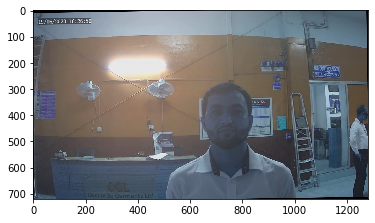

In [79]:
#.......extract images and face from video(by dlib).............
import dlib
import matplotlib.pyplot as plt

detector= dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("E:/eye_blink_detection/shape_predictor_68_face_landmarks.dat")

def extract_face(frame,face):
    x, y, w, h = face.left(), face.top(), face.width(), face.height()
    face_frame = frame[y: y + h, x: x + w].copy()
    return face_frame

def face_alignment(image,faces):
    #plt.imshow(image)
    face = faces[0]
    #print(faces[0])
    shapes = predictor(image, face)
    left_eye = extract_left_eye_center(shapes)
    right_eye = extract_right_eye_center(shapes)
    
    # eye center
    eye_center = ((left_eye[0] + right_eye[0]) // 2, (left_eye[1] + right_eye[1]) // 2)
    
    height, width = image.shape[0], image.shape[1]
    #M = cv2.getRotationMatrix2D(eye_center, angle, 1)
    M=get_rotation_matrix(left_eye,right_eye)
    #print(image)
    image=cv2.warpAffine(image, M, (width,height))
    #plt.imshow(image)
    return image

def face_alignment_1(img,faces):
    
    for i, det in enumerate(faces):
        shape = predictor(img, det)
        left_eye = extract_left_eye_center(shape)
        right_eye = extract_right_eye_center(shape)

        M = get_rotation_matrix(left_eye, right_eye)
        height, width = img.shape[0], img.shape[1]
        rotated = cv2.warpAffine(img, M, (width,height), flags=cv2.INTER_CUBIC)
        plt.imshow(rotated)

def extract_video(video,root_save_image):
     
    capture = cv2.VideoCapture(video)
    #print(capture)
    frames_num = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    #print(frames_num)

    #y_train=[]  
    for i in range(frames_num):
        capture.grab()
        if i % 50!= 0:
            continue
        success, frame = capture.retrieve()
        #print(frame) 
        if not success:
            continue
        id = os.path.splitext(os.path.basename(video))[0]
         
        #remove noise from frame_image
        #frame= cv2.fastNlMeansDenoisingColored(frame,None,10,10,7,21) 
        image_copy = np.copy(frame)
        
        #frame= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces=detector(frame)
        #draw a rectangle
        #face_crop = []
        #print(len(faces))
        
        if len(faces)>0:
            #print(faces)
            frame_1=face_alignment(image_copy,faces)
            #print(frame_1)
            #plt.imshow(frame_1)
            for face in faces:
                frame=extract_face(frame_1,face)
                #print(frame)
                #frame=face_alignment(frame,faces)
                #print(faces)
                #y_train.append(2)
                cv2.imwrite(os.path.join(root_save_image,"{}_{}.jpg".format(id, i)),frame) 
    
    #print(y_train)        

if __name__ == '__main__':
    
    root_save_image='E:/build_multi_face_recognizer/face_alignment/person2'
    videos='E:/individual_videos/person_2/person_2.mp4'
    extract_video(videos,root_save_image)




In [ ]:
from glob import glob

folder=glob('E:/build_multi_face_recognizer/face_reconiger/*.jpg')
#path = Path('E:/build_multi_face_recognizer/face_reconiger/*.jpg').expanduser()
folder = [x for x in folder]
print(len(folder))

In [5]:
def extract_face(frame,face):
    x, y, w, h = face.left(), face.top(), face.width(), face.height()
    face_frame = frame[y: y + h, x: x + w].copy()
    return face_frame
 

def extract_video(video,root_save_image,folder):
    
    c=0
    y_train=[]
    #print(len(video))
    for k in range(len(video)):
        c+=1
        if c==1:
            print(video[k])
            capture = cv2.VideoCapture(video[k])
            #print(capture)
            frames_num = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
            #print(frames_num)
            for i in range(frames_num):
                capture.grab()
                if i % 50!= 0:
                    continue
                success, frame = capture.retrieve()
                #print(frame) 
                if not success:
                    continue
                id = os.path.splitext(os.path.basename(video[k]))[0]
                #remove noise from frame_image
                #frame= cv2.fastNlMeansDenoisingColored(frame,None,10,10,7,21) 
                image_copy = np.copy(frame)
        
                #frame= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                faces=detector(frame)
                #draw a rectangle
                #face_crop = []
                #print(len(faces))
                if len(faces)>0:
                    for face in faces:
                        frame=extract_face(frame,face)
                        y_train.append(1)
                        #cv2.imwrite(os.path.join(root_save_image,"{}_{}.jpg".format(id, i)),frame)
        elif c==2:
            print(video[k])
            capture = cv2.VideoCapture(video[k])
            #print(capture)
            frames_num = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
            #print(frames_num)
            for i in range(frames_num):
                capture.grab()
                if i % 50!= 0:
                    continue
                success, frame = capture.retrieve()
                #print(frame) 
                if not success:
                    continue
                id = os.path.splitext(os.path.basename(video[k]))[0]
                #remove noise from frame_image
                #frame= cv2.fastNlMeansDenoisingColored(frame,None,10,10,7,21) 
                image_copy = np.copy(frame)
        
                #frame= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                faces=detector(frame)
                #draw a rectangle
                #face_crop = []
                #print(len(faces))
                if len(faces)>0:
                    for face in faces:
                        frame=extract_face(frame,face)
                        y_train.append(2)
                        #cv2.imwrite(os.path.join(root_save_image,"{}_{}.jpg".format(id, i)),frame)
            
            
        elif c==3:
            print(video[k])
            capture = cv2.VideoCapture(video[k])
            #print(capture)
            frames_num = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
            #print(frames_num)
            for i in range(frames_num):
                capture.grab()
                if i % 50!= 0:
                    continue
                success, frame = capture.retrieve()
                #print(frame) 
                if not success:
                    continue
                id = os.path.splitext(os.path.basename(video[k]))[0]
                #remove noise from frame_image
                #frame= cv2.fastNlMeansDenoisingColored(frame,None,10,10,7,21) 
                image_copy = np.copy(frame)
        
                #frame= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                faces=detector(frame)
                #draw a rectangle
                #face_crop = []
                #print(len(faces))
                if len(faces)>0:
                    for face in faces:
                        frame=extract_face(frame,face)
                        y_train.append(3)
                        #cv2.imwrite(os.path.join(root_save_image,"{}_{}.jpg".format(id, i)),frame)
        elif c==4:
            print(video[k])
            capture = cv2.VideoCapture(video[k])
            #print(capture)
            frames_num = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
            #print(frames_num)
            for i in range(frames_num):
                capture.grab()
                if i % 50!= 0:
                    continue
                success, frame = capture.retrieve()
                #print(frame) 
                if not success:
                    continue
                id = os.path.splitext(os.path.basename(video[k]))[0]
                #remove noise from frame_image
                #frame= cv2.fastNlMeansDenoisingColored(frame,None,10,10,7,21) 
                image_copy = np.copy(frame)
        
                #frame= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                faces=detector(frame)
                #draw a rectangle
                #face_crop = []
                #print(len(faces))
                if len(faces)>0:
                    for face in faces:
                        frame=extract_face(frame,face)
                        y_train.append(4)
                        #cv2.imwrite(os.path.join(root_save_image,"{}_{}.jpg".format(id, i)),frame)
            
        elif c==5:
            print(video[k])
            capture = cv2.VideoCapture(video[k])
            #print(capture)
            frames_num = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
            #print(frames_num)
            for i in range(frames_num):
                capture.grab()
                if i % 50!= 0:
                    continue
                success, frame = capture.retrieve()
                #print(frame) 
                if not success:
                    continue
                id = os.path.splitext(os.path.basename(video[k]))[0]
                #remove noise from frame_image
                #frame= cv2.fastNlMeansDenoisingColored(frame,None,10,10,7,21) 
                image_copy = np.copy(frame)
        
                #frame= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                faces=detector(frame)
                #draw a rectangle
                #face_crop = []
                #print(len(faces))
                if len(faces)>0:
                    for face in faces:
                        frame=extract_face(frame,face)
                        y_train.append(5)
                        #cv2.imwrite(os.path.join(root_save_image,"{}_{}.jpg".format(id, i)),frame)
        if c==6:
            print(video[k])
            capture = cv2.VideoCapture(video[k])
            #print(capture)
            frames_num = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
            #print(frames_num)
            for i in range(frames_num):
                capture.grab()
                if i % 50!= 0:
                    continue
                success, frame = capture.retrieve()
                #print(frame) 
                if not success:
                    continue
                id = os.path.splitext(os.path.basename(video[k]))[0]
                #remove noise from frame_image
                #frame= cv2.fastNlMeansDenoisingColored(frame,None,10,10,7,21) 
                image_copy = np.copy(frame)
        
                #frame= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                faces=detector(frame)
                #draw a rectangle
                #face_crop = []
                #print(len(faces))
                if len(faces)>0:
                    for face in faces:
                        frame=extract_face(frame,face)
                        y_train.append(6)
                        #cv2.imwrite(os.path.join(root_save_image,"{}_{}.jpg".format(id, i)),frame)
        if c==7:
            print(video[k])
            capture = cv2.VideoCapture(video[k])
            #print(capture)
            frames_num = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
            #print(frames_num)
            for i in range(frames_num):
                capture.grab()
                if i % 50!= 0:
                    continue
                success, frame = capture.retrieve()
                #print(frame) 
                if not success:
                    continue
                id = os.path.splitext(os.path.basename(video[k]))[0]
                #remove noise from frame_image
                #frame= cv2.fastNlMeansDenoisingColored(frame,None,10,10,7,21) 
                image_copy = np.copy(frame)
        
                #frame= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                faces=detector(frame)
                #draw a rectangle
                #face_crop = []
                #print(len(faces))
                if len(faces)>0:
                    for face in faces:
                        frame=extract_face(frame,face)
                        y_train.append(7)
                        #cv2.imwrite(os.path.join(root_save_image,"{}_{}.jpg".format(id, i)),frame)
            
        if c==8:
            print(video[k])
            capture = cv2.VideoCapture(video[k])
            #print(capture)
            frames_num = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
            #print(frames_num)
            for i in range(frames_num):
                capture.grab()
                if i % 50!= 0:
                    continue
                success, frame = capture.retrieve()
                #print(frame) 
                if not success:
                    continue
                id = os.path.splitext(os.path.basename(video[k]))[0]
                #remove noise from frame_image
                #frame= cv2.fastNlMeansDenoisingColored(frame,None,10,10,7,21) 
                image_copy = np.copy(frame)
        
                #frame= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                faces=detector(frame)
                #draw a rectangle
                #face_crop = []
                #print(len(faces))
                if len(faces)>0:
                    for face in faces:
                        frame=extract_face(frame,face)
                        y_train.append(8)
                        #cv2.imwrite(os.path.join(root_save_image,"{}_{}.jpg".format(id, i)),frame)
            
        if c==9:
            print(video[k])
            capture = cv2.VideoCapture(video[k])
            #print(capture)
            frames_num = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
            #print(frames_num)
            for i in range(frames_num):
                capture.grab()
                if i % 50!= 0:
                    continue
                success, frame = capture.retrieve()
                #print(frame) 
                if not success:
                    continue
                id = os.path.splitext(os.path.basename(video[k]))[0]
                #remove noise from frame_image
                #frame= cv2.fastNlMeansDenoisingColored(frame,None,10,10,7,21) 
                image_copy = np.copy(frame)
        
                #frame= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                faces=detector(frame)
                #draw a rectangle
                #face_crop = []
                #print(len(faces))
                if len(faces)>0:
                    for face in faces:
                        frame=extract_face(frame,face)
                        y_train.append(9)
                        #cv2.imwrite(os.path.join(root_save_image,"{}_{}.jpg".format(id, i)),frame)
        if c==10:
            print(video[k])
            capture = cv2.VideoCapture(video[k])
            #print(capture)
            frames_num = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
            #print(frames_num)
            for i in range(frames_num):
                capture.grab()
                if i % 50!= 0:
                    continue
                success, frame = capture.retrieve()
                #print(frame) 
                if not success:
                    continue
                id = os.path.splitext(os.path.basename(video[k]))[0]
                #remove noise from frame_image
                #frame= cv2.fastNlMeansDenoisingColored(frame,None,10,10,7,21) 
                image_copy = np.copy(frame)
        
                #frame= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                faces=detector(frame)
                #draw a rectangle
                #face_crop = []
                #print(len(faces))
                if len(faces)>0:
                    for face in faces:
                        frame=extract_face(frame,face)
                        y_train.append(10)
                        #cv2.imwrite(os.path.join(root_save_image,"{}_{}.jpg".format(id, i)),frame)
        
        elif c==11:
            print(video[k])
            capture = cv2.VideoCapture(video[k])
            #print(capture)
            frames_num = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
            #print(frames_num)
            for i in range(frames_num):
                capture.grab()
                if i % 50!= 0:
                    continue
                success, frame = capture.retrieve()
                #print(frame) 
                if not success:
                    continue
                id = os.path.splitext(os.path.basename(video[k]))[0]
                #remove noise from frame_image
                #frame= cv2.fastNlMeansDenoisingColored(frame,None,10,10,7,21) 
                image_copy = np.copy(frame)
        
                #frame= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                faces=detector(frame)
                #draw a rectangle
                #face_crop = []
                #print(len(faces))
                if len(faces)>0:
                    for face in faces:
                        frame=extract_face(frame,face)
                        y_train.append(11)
                        #cv2.imwrite(os.path.join(root_save_image,"{}_{}.jpg".format(id, i)),frame)
        
        elif c==12:
            print(video[k])
            capture = cv2.VideoCapture(video[k])
            #print(capture)
            frames_num = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
            #print(frames_num)
            for i in range(frames_num):
                capture.grab()
                if i % 50!= 0:
                    continue
                success, frame = capture.retrieve()
                #print(frame) 
                if not success:
                    continue
                id = os.path.splitext(os.path.basename(video[k]))[0]
                #remove noise from frame_image
                #frame= cv2.fastNlMeansDenoisingColored(frame,None,10,10,7,21) 
                image_copy = np.copy(frame)
        
                #frame= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                faces=detector(frame)
                #draw a rectangle
                #face_crop = []
                #print(len(faces))
                if len(faces)>0:
                    for face in faces:
                        frame=extract_face(frame,face)
                        y_train.append(12)
                        #cv2.imwrite(os.path.join(root_save_image,"{}_{}.jpg".format(id, i)),frame)
        
        elif c==13:
            print(video[k])
            capture = cv2.VideoCapture(video[k])
            #print(capture)
            frames_num = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
            #print(frames_num)
            for i in range(frames_num):
                capture.grab()
                if i % 50!= 0:
                    continue
                success, frame = capture.retrieve()
                #print(frame) 
                if not success:
                    continue
                id = os.path.splitext(os.path.basename(video[k]))[0]
                #remove noise from frame_image
                #frame= cv2.fastNlMeansDenoisingColored(frame,None,10,10,7,21) 
                image_copy = np.copy(frame)
        
                #frame= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                faces=detector(frame)
                #draw a rectangle
                #face_crop = []
                #print(len(faces))
                if len(faces)>0:
                    for face in faces:
                        frame=extract_face(frame,face)
                        y_train.append(13)
                        #cv2.imwrite(os.path.join(root_save_image,"{}_{}.jpg".format(id, i)),frame)
        elif c==14:
            print(video[k])
            capture = cv2.VideoCapture(video[k])
            #print(capture)
            frames_num = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
            #print(frames_num)
            for i in range(frames_num):
                capture.grab()
                if i % 50!= 0:
                    continue
                success, frame = capture.retrieve()
                #print(frame) 
                if not success:
                    continue
                id = os.path.splitext(os.path.basename(video[k]))[0]
                #remove noise from frame_image
                #frame= cv2.fastNlMeansDenoisingColored(frame,None,10,10,7,21) 
                image_copy = np.copy(frame)
        
                #frame= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                faces=detector(frame)
                #draw a rectangle
                #face_crop = []
                #print(len(faces))
                if len(faces)>0:
                    for face in faces:
                        frame=extract_face(frame,face)
                        y_train.append(14)
                        #cv2.imwrite(os.path.join(root_save_image,"{}_{}.jpg".format(id, i)),frame)
        elif c==15:
            print(video[k])
            capture = cv2.VideoCapture(video[k])
            #print(capture)
            frames_num = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
            #print(frames_num)
            for i in range(frames_num):
                capture.grab()
                if i % 50!= 0:
                    continue
                success, frame = capture.retrieve()
                #print(frame) 
                if not success:
                    continue
                id = os.path.splitext(os.path.basename(video[k]))[0]
                #remove noise from frame_image
                #frame= cv2.fastNlMeansDenoisingColored(frame,None,10,10,7,21) 
                image_copy = np.copy(frame)
        
                #frame= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                faces=detector(frame)
                #draw a rectangle
                #face_crop = []
                #print(len(faces))
                if len(faces)>0:
                    for face in faces:
                        frame=extract_face(frame,face)
                        y_train.append(15)
                        #cv2.imwrite(os.path.join(root_save_image,"{}_{}.jpg".format(id, i)),frame)
        
        #else:
            #break
            
    print(y_train)       
    return y_train
 

if __name__ == '__main__':    
    root_save_image='E:/build_multi_face_recognizer/face_reconiger_new/person15/'
    #videos='E:/individual_videos/person_10/person_10.mp4'
    #extract_video(videos,root_save_image,folder)
    
    #for i in root_dir:
        #videos=f"E:/build_multi_face_recognizer/video[i]"
    
    folders="E:/build_multi_face_recognizer/video"
    #folders=
    vid=[]
    for filename in os.listdir(folders):
        if any([filename.endswith(x) for x in ['.mp4']]):
            vid.append(os.path.join(folders,filename))
    
    #print(len(vid))
    #def last(x):
        #return (x[-6:-1])
    
    #vid=sorted(vid,key=last)
    #now sort the video file sequentially..
    
    from tkinter import Tcl
    vid=Tcl().call('lsort', '-dict',vid)
    #print(vid)
    y_train=extract_video(vid,root_save_image,folder)
        


E:/build_multi_face_recognizer/video\person_1.mp4
E:/build_multi_face_recognizer/video\person_2.mp4
E:/build_multi_face_recognizer/video\person_3.mp4
E:/build_multi_face_recognizer/video\person_4.mp4
E:/build_multi_face_recognizer/video\person_5.mp4
E:/build_multi_face_recognizer/video\person_6.mp4
E:/build_multi_face_recognizer/video\person_7.mp4
E:/build_multi_face_recognizer/video\person_8.mp4
E:/build_multi_face_recognizer/video\person_9.mp4
E:/build_multi_face_recognizer/video\person_10.mp4
E:/build_multi_face_recognizer/video\person_11.mp4
E:/build_multi_face_recognizer/video\person_12.mp4
E:/build_multi_face_recognizer/video\person_13.mp4
E:/build_multi_face_recognizer/video\person_14.mp4
E:/build_multi_face_recognizer/video\person_15.mp4
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

In [6]:
#.......extract images from video(by MTCNN).............
from mtcnn import MTCNN
detector_1 = MTCNN()

def extract_face(frame,face):
    x, y, w, h = face.left(), face.top(), face.width(), face.height()
    face_frame = frame[y: y + h, x: x + w].copy()
    return face_frame


    
 

def extract_video(video,root_save_image):
     
    capture = cv2.VideoCapture(video)
    #print(capture)
    frames_num = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    #print(frames_num)

     
    for i in range(frames_num):
        capture.grab()
        #if i % 5 != 0:
            #continue
        success, frame = capture.retrieve()
        #print(frame) 
        if not success:
            continue
        id = os.path.splitext(os.path.basename(video))[0]
        
        #remove noise from frame_image
        frame= cv2.fastNlMeansDenoisingColored(frame,None,10,10,7,21)
         
        image_copy = np.copy(frame)
        #frame= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        #faces=detector_1(frame)
        faces= detector_1.detect_faces(frame)
         
        if len(faces)>0:
            
            faces=face_alignment(faces)
            for face in faces:
                print(face)
                x, y, w,h = face['box']
                frame=frame[y: y + h, x: x + w].copy()
             
                cv2.imwrite(os.path.join(root_save_image,"{}_{}.jpg".format(id, i)),frame)
                     
                   

if __name__ == '__main__':
    
    root_save_image='E:/face_reconiger/person10.jpg/'
    videos='E:/individual_videos/person_10/person_10.mp4'
    #extract_video(videos,root_save_image)



Using TensorFlow backend.


In [7]:
import glob
from pathlib import Path

#folder = Path('').rglob('*.jpg')
folder = glob.glob(r'E:/*/*.jpg')
folder = [x for x in folder]
print(folder)

['E:/anomaly_detection\\Capture.JPG', 'E:/anomaly_detection\\loss.jpg']


In [8]:
#Read folders from pc/laptop
from glob import glob
folder=glob('E:/build_multi_face_recognizer/face_reconiger/*.jpg')
#path = Path('E:/build_multi_face_recognizer/face_reconiger/*.jpg').expanduser()
folder = [x for x in folder]
print(len(folder))


15


In [9]:
import random
random_seed = 1
random.seed(random_seed)
numpy_seed = 1
np.random.seed(numpy_seed)

In [10]:
#combine images from multiple folders
import random

#def load_images_from_folder(folder):
    #images = []
    #for filename in os.listdir(folder):
        #if any([filename.endswith(x) for x in ['.jpg']]):
            #img = cv2.imread(os.path.join(folder, filename))
            #print(img)
            #img=random.choice(img)
            #images.append(img)
    #return images

folders = [
    'E:/build_multi_face_recognizer/face_reconiger/person1.jpg',
    'E:/build_multi_face_recognizer/face_reconiger/person2.jpg',
    'E:/build_multi_face_recognizer/face_reconiger/person3.jpg',
    'E:/build_multi_face_recognizer/face_reconiger/person4.jpg',
    'E:/build_multi_face_recognizer/face_reconiger/person5.jpg',
    'E:/build_multi_face_recognizer/face_reconiger/person6.jpg',
    'E:/build_multi_face_recognizer/face_reconiger/person7.jpg',
    'E:/build_multi_face_recognizer/face_reconiger/person8.jpg',
    'E:/build_multi_face_recognizer/face_reconiger/person9.jpg',
    'E:/build_multi_face_recognizer/face_reconiger/person10.jpg',
    'E:/build_multi_face_recognizer/face_reconiger/person11.jpg',
    'E:/build_multi_face_recognizer/face_reconiger/person12.jpg',
    'E:/build_multi_face_recognizer/face_reconiger/person13.jpg',
    'E:/build_multi_face_recognizer/face_reconiger/person14.jpg',
    'E:/build_multi_face_recognizer/face_reconiger/person15.jpg',     
]

file=[]
for folder in folders:
    #images = load_images_from_folder(folder)
    for filename in os.listdir(folder):
        if any([filename.endswith(x) for x in ['.jpg']]):
            file.append(os.path.join(folder, filename))


#print(file)  
print(len(file))
chosen_images = np.random.choice(file,size=1000)
print(chosen_images )
print(len(chosen_images))

random_images=[]
for i in chosen_images:
    images=cv2.imread(i)
    #print(images)
    if images is not None:
        random_images.append(images)
         
print(len(random_images))

17025
['E:/build_multi_face_recognizer/face_reconiger/person1.jpg\\person_1_1213.jpg'
 'E:/build_multi_face_recognizer/face_reconiger/person11.jpg\\person_11_964.jpg'
 'E:/build_multi_face_recognizer/face_reconiger/person5.jpg\\person_5_1088.jpg'
 'E:/build_multi_face_recognizer/face_reconiger/person9.jpg\\person_9_2100.jpg'
 'E:/build_multi_face_recognizer/face_reconiger/person7.jpg\\person_7_260.jpg'
 'E:/build_multi_face_recognizer/face_reconiger/person1.jpg\\person_1_1130.jpg'
 'E:/build_multi_face_recognizer/face_reconiger/person15.jpg\\person_15_164.jpg'
 'E:/build_multi_face_recognizer/face_reconiger/person7.jpg\\person_7_198.jpg'
 'E:/build_multi_face_recognizer/face_reconiger/person9.jpg\\person_9_2134.jpg'
 'E:/build_multi_face_recognizer/face_reconiger/person4.jpg\\person_4_102.jpg'
 'E:/build_multi_face_recognizer/face_reconiger/person12.jpg\\person_12_1443.jpg'
 'E:/build_multi_face_recognizer/face_reconiger/person3.jpg\\person_3_483.jpg'
 'E:/build_multi_face_recognizer/f

In [11]:
#chosen_images[0]

In [12]:
def l2_normalize(x,axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

In [13]:
# for random_images
from keras_facenet import FaceNet
embedder = FaceNet()
embed_random_images = embedder.embeddings(random_images)
#print(embedd)
emb_random_images= l2_normalize(embed_random_images)
print(emb_random_images)

from pathlib import Path
path = Path('E:/build_multi_face_recognizer').expanduser()
path.mkdir(parents=True, exist_ok=True)

 
np.save(path/'save_emb_random_images',emb_random_images)
     

[[ 0.06445881  0.0791121   0.00370562 ... -0.01496174  0.02847866
  -0.05160658]
 [ 0.04669368  0.04366694 -0.0342759  ... -0.03120752  0.01297054
  -0.02373906]
 [-0.01359671  0.06284313 -0.03851875 ... -0.02720069 -0.00640916
  -0.01017704]
 ...
 [ 0.05233319  0.02544624 -0.05018038 ... -0.07284591 -0.03574499
   0.00641904]
 [ 0.04700723 -0.01446219 -0.00652236 ... -0.07848467 -0.07568129
   0.00303582]
 [ 0.01667005  0.05278195 -0.03388026 ... -0.0504443  -0.04302119
   0.02732713]]


In [14]:
emb_random_images= np.load(path/'save_emb_random_images.npy')
print(emb_random_images)
print(len(emb_random_images))

[[ 0.06445881  0.0791121   0.00370562 ... -0.01496174  0.02847866
  -0.05160658]
 [ 0.04669368  0.04366694 -0.0342759  ... -0.03120752  0.01297054
  -0.02373906]
 [-0.01359671  0.06284313 -0.03851875 ... -0.02720069 -0.00640916
  -0.01017704]
 ...
 [ 0.05233319  0.02544624 -0.05018038 ... -0.07284591 -0.03574499
   0.00641904]
 [ 0.04700723 -0.01446219 -0.00652236 ... -0.07848467 -0.07568129
   0.00303582]
 [ 0.01667005  0.05278195 -0.03388026 ... -0.0504443  -0.04302119
   0.02732713]]
1000


In [15]:
#for references image

refer_folders=[
    "E:/build_multi_face_recognizer/face_folder/person_1_face",
    "E:/build_multi_face_recognizer/face_folder/person_2_face",
    "E:/build_multi_face_recognizer/face_folder/person_3_face",
    "E:/build_multi_face_recognizer/face_folder/person_4_face",
    "E:/build_multi_face_recognizer/face_folder/person_5_face",
    "E:/build_multi_face_recognizer/face_folder/person_6_face",
    "E:/build_multi_face_recognizer/face_folder/person_7_face",
    "E:/build_multi_face_recognizer/face_folder/person_8_face",
    "E:/build_multi_face_recognizer/face_folder/person_9_face",
    "E:/build_multi_face_recognizer/face_folder/person_10_face",
    "E:/build_multi_face_recognizer/face_folder/person_11_face",
    "E:/build_multi_face_recognizer/face_folder/person_12_face",
    "E:/build_multi_face_recognizer/face_folder/person_13_face",
    "E:/build_multi_face_recognizer/face_folder/person_14_face",
    "E:/build_multi_face_recognizer/face_folder/person_15_face",
    ]

file=[]
for folder in refer_folders:
    #images = load_images_from_folder(folder)
    for filename in os.listdir(folder):
        if any([filename.endswith(x) for x in ['.jpg']]):
            file.append(os.path.join(folder, filename))
            
refer_images=[]
for i in file:
    images=cv2.imread(i)
    #print(images)
    if images is not None:
        refer_images.append(images)

embedd_refer_images =embedder.embeddings(refer_images)
#print(embedd)
emb_refer_images= l2_normalize(embedd_refer_images)
print(len(emb_refer_images))
print(emb_refer_images)

15
[[ 0.06039529  0.05652209 -0.01835996 ... -0.07520905  0.03753061
  -0.03265794]
 [ 0.04910308  0.05943264 -0.05404302 ... -0.06543362 -0.01308956
   0.02872852]
 [ 0.09900416 -0.02695236 -0.09545269 ... -0.00194565 -0.01829052
  -0.04606238]
 ...
 [ 0.05075666 -0.08885103 -0.06491967 ...  0.11564379 -0.01878983
  -0.06492727]
 [ 0.03125917  0.01650573 -0.03364809 ... -0.10303669 -0.03896675
   0.03231096]
 [ 0.07562126  0.02681441 -0.01650297 ... -0.02937    -0.04888527
  -0.04559724]]


In [16]:
path1 = Path('E:/build_multi_face_recognizer').expanduser()
path1.mkdir(parents=True, exist_ok=True)
np.save(path1/'save_emb_refer_images',emb_refer_images)

emb_refer_images= np.load(path/'save_emb_refer_images.npy')
print(len(emb_refer_images))

15


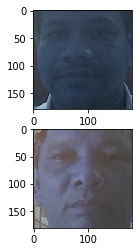

(180, 180, 3)
(181, 180, 3)
(1, 512)
(1, 512)
0.7392809391021729


In [17]:
#now fixing threshold value by comparing single random_img and single refer_img
import cv2
from scipy.spatial import distance

#random_img
rand_imgs=cv2.imread("E:/build_multi_face_recognizer/face_reconiger/person1.jpg/person_1_1138.jpg")
refer_imgs=cv2.imread("E:/build_multi_face_recognizer/face_folder/person_10_face/person_10_297.jpg")
#refer_imgs=cv2.imread("E:/Abdul Qyum/Qyum.png")
#plt.imshow(rand_imgs)

plt.figure(1)
plt.subplot(211)
plt.imshow(rand_imgs)

plt.subplot(212)
plt.imshow(refer_imgs)
plt.show()

print(rand_imgs.shape)
rand_imgs=[rand_imgs]
rand_imgs=embedder.embeddings(rand_imgs)
rand_imgs= l2_normalize(rand_imgs)
#print(rand_img)


#refer_img
 
print(refer_imgs.shape)
#plt.imshow(refer_imgs)
refer_imgs=[refer_imgs]
refer_imgs=embedder.embeddings(refer_imgs)
refer_imgs= l2_normalize(refer_imgs)
#print(refer_imgs)



#refer_imgs=refer_imgs.flatten()
print(refer_imgs.shape)
#rand_imgs=rand_imgs.flatten()
print(rand_imgs.shape)

#determine the euclidien distance
euc_dist=distance.euclidean(rand_imgs,refer_imgs)
print(euc_dist)

In [18]:
from glob import glob
from scipy.spatial import distance
font = cv2.FONT_HERSHEY_PLAIN

#1:k compare with refer images and random images
print(len(emb_refer_images))
print(len(emb_random_images))
euc_d=[]
y_pred=[]
for i in range(0,len(emb_refer_images)):
    #r_img=refer_img[i]
    #print(r_img)
    for j in range(0,len(emb_random_images)):
        euc_dist=distance.euclidean(emb_refer_images[i],emb_random_images[j])
        print(euc_dist)
        euc_d.append(euc_dist)
         

        if euc_dist<0.70:
            print("Men Recognize")
            y_pred.append(0)
            #cv2.putText(refer_img[i],"Men Recognize: {}".format(euc_dist), (20, 20), font, 2, (255, 0, 0),2)
            #cv2.putText(random_img[j],"Men Recognize: {}".format(euc_dist), (20, 20), font, 2,  (255, 0, 0),2)
        else:
            print("Not Recognize")
            y_pred.append(1)
            #(255, 0, 0),2)  
            #return euc_dist
        
#print(y_pred)                                                                                              

15
1000
0.55888831615448
Men Recognize
1.0898410081863403
Not Recognize
1.044148325920105
Not Recognize
1.2190715074539185
Not Recognize
1.093358039855957
Not Recognize
0.6043605208396912
Men Recognize
1.0009366273880005
Not Recognize
1.173697829246521
Not Recognize
1.1482548713684082
Not Recognize
1.3300402164459229
Not Recognize
1.0174182653427124
Not Recognize
1.1871341466903687
Not Recognize
1.3578757047653198
Not Recognize
1.3106530904769897
Not Recognize
1.069942593574524
Not Recognize
1.0781569480895996
Not Recognize
0.5696131587028503
Men Recognize
1.0800724029541016
Not Recognize
0.5027626156806946
Men Recognize
1.2820862531661987
Not Recognize
1.2760601043701172
Not Recognize
1.166062831878662
Not Recognize
1.1857647895812988
Not Recognize
1.1801010370254517
Not Recognize
0.4699867367744446
Men Recognize
1.2444332838058472
Not Recognize
1.1920390129089355
Not Recognize
1.1257737874984741
Not Recognize
1.2039891481399536
Not Recognize
1.350938081741333
Not Recognize
1.08878195

In [19]:
#print(y_pred)
#print(len(y_pred))



In [20]:
#.........................data preparation to train model................

#....read folders....
folder_t=glob('E:/build_multi_face_recognizer/face_reconiger_new/*')
#path = Path('E:/build_multi_face_recognizer/face_reconiger/*.jpg').expanduser()
folder_t = [x for x in folder_t]
#print(len(folder_t))
#print(folder)

from tkinter import Tcl
folder_t=Tcl().call('lsort', '-dict',folder_t)
#print(folder_t)

file=[]
for folder in folder_t:
    #images = load_images_from_folder(folder)
    for filename in os.listdir(folder):
        if any([filename.endswith(x) for x in ['.jpg']]):
            file.append(os.path.join(folder, filename))


  
#print(len(file))

train_images=[]
for i in file:
    images=cv2.imread(i)
    #print(images)
    if images is not None:
        train_images.append(images)
         
#print(len(train_images))
#print(len(y_train))

#..............train_label..............
train_label=y_train
#.................now use pre_trained_model to get embedd................... 
train_images =embedder.embeddings(train_images)
#print(embedd)
train_images= l2_normalize(train_images)
print(len(train_images))
#print(train_images)


330


In [21]:
#...........................build and train model........................

from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing

y=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

model = KNeighborsClassifier(n_neighbors=5)
model.fit(train_images,train_label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [22]:
#now predict label using embed_refer_images(test_image)
y_pred_test=model.predict(emb_refer_images)
print(y_pred_test)

#measure accuracy
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


accuracy=accuracy_score(y,y_pred_test)
print("Accuracy:",accuracy)

matrix = confusion_matrix(y,y_pred_test)
print("confusion matrix:",matrix)


#print("Recall Score : ",recall_score(y,y_pred_test, 
                                          # pos_label='positive',
                                          # average='macro'
                                           #))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Accuracy: 1.0
confusion matrix: [[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]


In [23]:
print("Precision Score : ",precision_score(y,y_pred_test, 
                                           #pos_label='positive',
                                           average='micro',
                                          ))

Precision Score :  1.0


In [24]:
report = classification_report(y,y_pred_test)
print(report)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         1

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00   

In [25]:
#import face_recognition
#closest_dist = model.kneighbors(refer_imgs, n_neighbors=1)
#are_matches = [closest_distances[0][i][0] <=0.6 for i in refer_imgs]
#print(closest_dist)

In [26]:
#refer_imgs_1=cv2.imread("E:/Abdul Qyum/Qyum.png")
refer_imgs_1=cv2.imread('E:/build_multi_face_recognizer/face_reconiger/person1.jpg/person_1_1000.jpg')
#refer_img
print(refer_imgs.shape)
 
refer_imgs=[refer_imgs_1]
refer_imgs=embedder.embeddings(refer_imgs)
refer_imgs= l2_normalize(refer_imgs)
#print(refer_imgs)


y_pred=model.predict(refer_imgs)
print(y_pred)

closest_dist = model.kneighbors(refer_imgs,n_neighbors=1)
 
print(closest_dist[0])
if closest_dist[0]<0.7:
    print("recognize")
else:
    print("not recognize")
#are_matches = [closest_dist[0][i][0] <0.6 for i in refer_imgs_1]
#print(closest_dist)

(1, 512)
[3]
[[4.44176064e-07]]
recognize


In [27]:
#.......................make label for random sample.................
test_file=[]
y=[]
c=0
for folder in folders:
    #images = load_images_from_folder(folder)
    c+=1
    if c==1:
        j=0
        for filename in os.listdir(folder):
            j+=1
            if j<=3:
                if any([filename.endswith(x) for x in ['.jpg']]):
                    file_1=os.path.join(folder, filename)
                    #print(file_1)
                    #file_2=np.random.choice(file_1,3)
                    test_file.append(file_1)
                    y.append(1)
            else:
                break
    elif c==2:
        j=0
        for filename in os.listdir(folder):
            j+=1
            if j<=3:
                if any([filename.endswith(x) for x in ['.jpg']]):
                    file_1=os.path.join(folder, filename)
                    #print(file_1)
                    #file_2=np.random.choice(file_1,3)
                    test_file.append(file_1)
                    y.append(2)
            else:
                break
    elif c==3:
        j=0
        for filename in os.listdir(folder):
            j+=1
            if j<=3:
                if any([filename.endswith(x) for x in ['.jpg']]):
                    file_1=os.path.join(folder, filename)
                    #print(file_1)
                    #file_2=np.random.choice(file_1,3)
                    test_file.append(file_1)
                    y.append(3)
            else:
                break
    elif c==4:
        j=0
        for filename in os.listdir(folder):
            j+=1
            if j<=3:
                if any([filename.endswith(x) for x in ['.jpg']]):
                    file_1=os.path.join(folder, filename)
                    #print(file_1)
                    #file_2=np.random.choice(file_1,3)
                    test_file.append(file_1)
                    y.append(4)
            else:
                break
    elif c==5:
        j=0
        for filename in os.listdir(folder):
            j+=1
            if j<=3:
                if any([filename.endswith(x) for x in ['.jpg']]):
                    file_1=os.path.join(folder, filename)
                    #print(file_1)
                    #file_2=np.random.choice(file_1,3)
                    test_file.append(file_1)
                    y.append(5)
            else:
                break
    elif c==6:
        j=0
        for filename in os.listdir(folder):
            j+=1
            if j<=3:
                if any([filename.endswith(x) for x in ['.jpg']]):
                    file_1=os.path.join(folder, filename)
                    #print(file_1)
                    #file_2=np.random.choice(file_1,3)
                    test_file.append(file_1)
                    y.append(6)
            else:
                break
    elif c==7:
        j=0
        for filename in os.listdir(folder):
            j+=1
            if j<=3:
                if any([filename.endswith(x) for x in ['.jpg']]):
                    file_1=os.path.join(folder, filename)
                    #print(file_1)
                    #file_2=np.random.choice(file_1,3)
                    test_file.append(file_1)
                    y.append(7)
            else:
                break
    elif c==8:
        j=0
        for filename in os.listdir(folder):
            j+=1
            if j<=3:
                if any([filename.endswith(x) for x in ['.jpg']]):
                    file_1=os.path.join(folder, filename)
                    #print(file_1)
                    #file_2=np.random.choice(file_1,3)
                    test_file.append(file_1)
                    y.append(8)
            else:
                break
    elif c==9:
        j=0
        for filename in os.listdir(folder):
            j+=1
            if j<=3:
                if any([filename.endswith(x) for x in ['.jpg']]):
                    file_1=os.path.join(folder, filename)
                    #print(file_1)
                    #file_2=np.random.choice(file_1,3)
                    test_file.append(file_1)
                    y.append(9)
            else:
                break
    elif c==10:
        j=0
        for filename in os.listdir(folder):
            j+=1
            if j<=3:
                if any([filename.endswith(x) for x in ['.jpg']]):
                    file_1=os.path.join(folder, filename)
                    #print(file_1)
                    #file_2=np.random.choice(file_1,3)
                    test_file.append(file_1)
                    y.append(10)
            else:
                break
    elif c==11:
        j=0
        for filename in os.listdir(folder):
            j+=1
            if j<=3:
                if any([filename.endswith(x) for x in ['.jpg']]):
                    file_1=os.path.join(folder, filename)
                    #print(file_1)
                    #file_2=np.random.choice(file_1,3)
                    test_file.append(file_1)
                    y.append(11)
            else:
                break
    elif c==12:
        j=0
        for filename in os.listdir(folder):
            j+=1
            if j<=3:
                if any([filename.endswith(x) for x in ['.jpg']]):
                    file_1=os.path.join(folder, filename)
                    #print(file_1)
                    #file_2=np.random.choice(file_1,3)
                    test_file.append(file_1)
                    y.append(12)
            else:
                break
    elif c==13:
        j=0
        for filename in os.listdir(folder):
            j+=1
            if j<=3:
                if any([filename.endswith(x) for x in ['.jpg']]):
                    file_1=os.path.join(folder, filename)
                    #print(file_1)
                    #file_2=np.random.choice(file_1,3)
                    test_file.append(file_1)
                    y.append(13)
            else:
                break
    elif c==14:
        j=0
        for filename in os.listdir(folder):
            j+=1
            if j<=3:
                if any([filename.endswith(x) for x in ['.jpg']]):
                    file_1=os.path.join(folder, filename)
                    #print(file_1)
                    #file_2=np.random.choice(file_1,3)
                    test_file.append(file_1)
                    y.append(14)
            else:
                break
    elif c==15:
        j=0
        for filename in os.listdir(folder):
            j+=1
            if j<=3:
                if any([filename.endswith(x) for x in ['.jpg']]):
                    file_1=os.path.join(folder, filename)
                    #print(file_1)
                    #file_2=np.random.choice(file_1,3)
                    test_file.append(file_1)
                    y.append(15)
            else:
                break
    else:
        break
     
print(test_file)
print(y)

['E:/build_multi_face_recognizer/face_reconiger/person1.jpg\\person_1_100.jpg', 'E:/build_multi_face_recognizer/face_reconiger/person1.jpg\\person_1_1000.jpg', 'E:/build_multi_face_recognizer/face_reconiger/person1.jpg\\person_1_1001.jpg', 'E:/build_multi_face_recognizer/face_reconiger/person2.jpg\\person_2_1000.jpg', 'E:/build_multi_face_recognizer/face_reconiger/person2.jpg\\person_2_1001.jpg', 'E:/build_multi_face_recognizer/face_reconiger/person2.jpg\\person_2_1002.jpg', 'E:/build_multi_face_recognizer/face_reconiger/person3.jpg\\person_3_1000.jpg', 'E:/build_multi_face_recognizer/face_reconiger/person3.jpg\\person_3_1001.jpg', 'E:/build_multi_face_recognizer/face_reconiger/person3.jpg\\person_3_1002.jpg', 'E:/build_multi_face_recognizer/face_reconiger/person4.jpg\\person_4_100.jpg', 'E:/build_multi_face_recognizer/face_reconiger/person4.jpg\\person_4_1000.jpg', 'E:/build_multi_face_recognizer/face_reconiger/person4.jpg\\person_4_1001.jpg', 'E:/build_multi_face_recognizer/face_reco

In [28]:
print(len(test_file))

45


In [29]:
import pandas as pd
test_data = pd.DataFrame({"img_file": test_file,
                         "label":y,
                         })
test_data.head(10)

,img_file,label
0,E:/build_multi_face_recognizer/face_reconiger/...,1
1,E:/build_multi_face_recognizer/face_reconiger/...,1
2,E:/build_multi_face_recognizer/face_reconiger/...,1
3,E:/build_multi_face_recognizer/face_reconiger/...,2
4,E:/build_multi_face_recognizer/face_reconiger/...,2
5,E:/build_multi_face_recognizer/face_reconiger/...,2
6,E:/build_multi_face_recognizer/face_reconiger/...,3
7,E:/build_multi_face_recognizer/face_reconiger/...,3
8,E:/build_multi_face_recognizer/face_reconiger/...,3
9,E:/build_multi_face_recognizer/face_reconiger/...,4


In [30]:
#..........................test_img read and predict....................

test_img=[]
for i in test_file:
    images=cv2.imread(i)
    #print(images)
    if images is not None:
        test_img.append(images)
print(len(test_img))
test_img=embedder.embeddings(test_img)
#print(embedd)
test_img= l2_normalize(test_img)
#print(len(test_img))

#.......now pass the test_img through the model..........
y_pred_test=model.predict(test_img)
print(y_pred_test)

45
[ 1  3  3  2  2  2  3  3  3  4  4  4  5  5  5  6  9  6  7  7  7  9  8  8
  9  9  9  3  3 10 11 11 11 12 12 12 13 13 13 14 14 14 15 15 15]


In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
accuracy=accuracy_score(y,y_pred_test)
print("Precision Score : ",precision_score(y,y_pred_test, 
                                           #pos_label='positive',
                                           average='micro'))
print("Recall Score : ",recall_score(y,y_pred_test, 
                                          # pos_label='positive',
                                           average='micro'))
print(accuracy)

Precision Score :  0.8666666666666667
Recall Score :  0.8666666666666667
0.8666666666666667


0.0


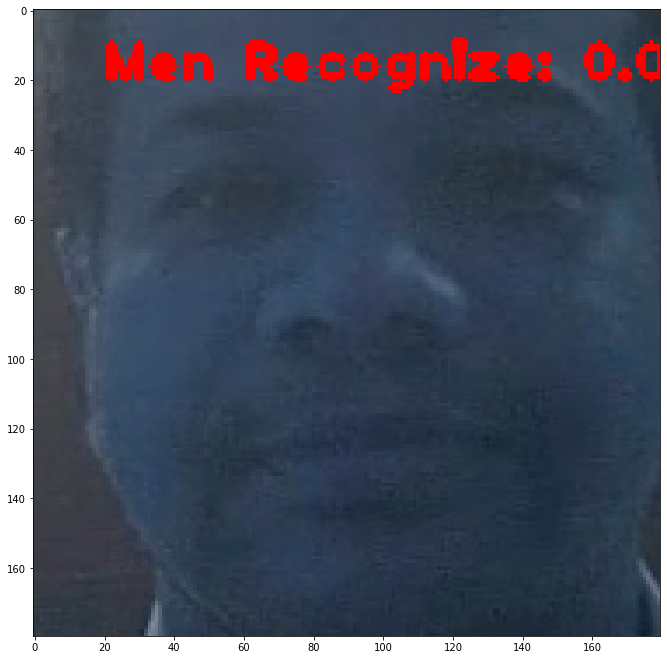

1.256861925125122


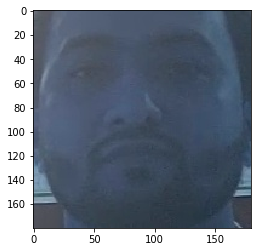

1.0837918519973755


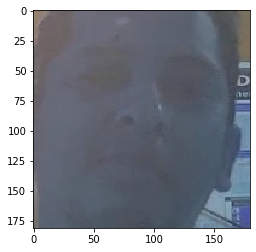

1.4186451435089111


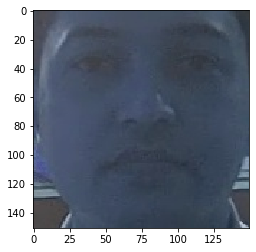

1.1833984851837158


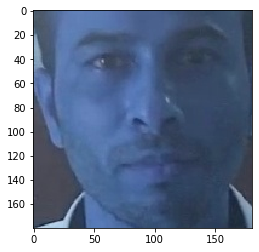

1.2398582696914673


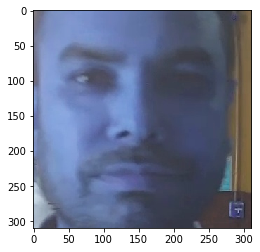

1.2014482021331787


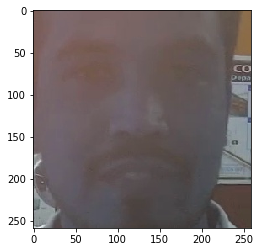

1.2175146341323853


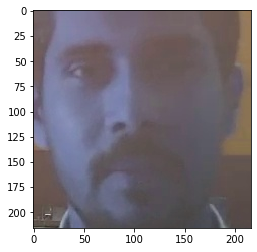

1.1256088018417358


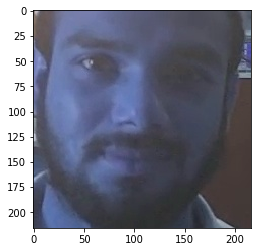

0.9077304601669312


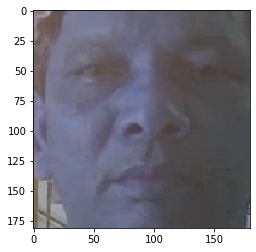

1.195712685585022


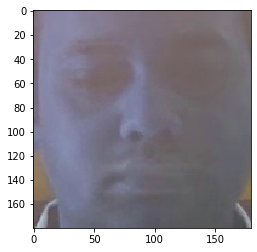

1.0370361804962158


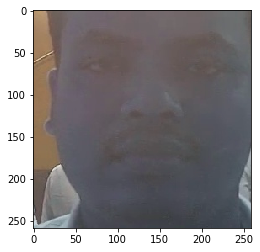

1.3231987953186035


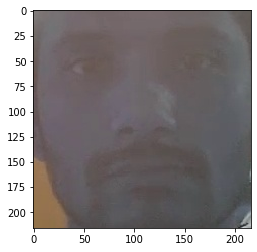

1.2040413618087769


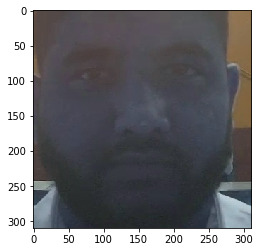

1.0433214902877808


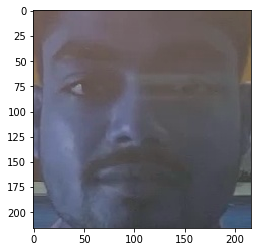

In [32]:
from matplotlib.pyplot import figure

#random_images=random_images
#n=len(random_images)
#print(n)

refer_images=refer_images
m=len(refer_images)
#print(refer_images[0])
#print(refer_images.shape)

f = plt.figure(figsize=(200, 200))
#h=plt.figure(figsize=(200, 200))
for i in range(0,m):
    #refer image one
    refer_images_1=embedder.embeddings(refer_images)
    refer_images_1= l2_normalize(refer_images_1)
    #print(refer_images_1)
    #random images
    random_images_m=embedder.embeddings(refer_images)
    random_images_m= l2_normalize(random_images_m)
    
    euc_d=distance.euclidean(refer_images_1[0],random_images_m[i])
    print(euc_d)
    
    
    if euc_d<0.1:
        cv2.putText(refer_images[0],"Men Recognize: {}".format(euc_d), (20, 20), font,1,(255, 0, 0),2)
        #cv2.putText(random_images[i],"Men Recognize: {}".format(euc_d), (20, 20), font, 1, (255, 0, 0),2)  
            
        f.add_subplot(1,m,i+1)
        plt.imshow(refer_images[0])
        plt.show()
    else:
        #cv2.putText(refer_images[0],"Not Recognize: {}".format(euc_d), (20, 20),font, 2,(255, 0, 0),2)
        cv2.putText(random_images[i],"Not Recognize: {}".format(euc_d), (20, 20),font,2,(255, 0, 0),2) 
        f.add_subplot(m,1,i+1)
        plt.imshow(refer_images[i])
        plt.show()   
    
 
    #for j in range(n):
        # Debug, plot figure
        #refer_img_pic
        #print(euc_d[j])
       
        #random_img_pic
        #f.add_subplot(m,1,j+1)
        #plt.imshow(rand_img_1[i])
        
         
        
         
#plt.show(block=True)

In [33]:
#........................generate label for image data..............................
from PIL import ImageChops
#import ImageChops

refer_img_l=refer_images
print(len(refer_img_l))
random_img_l=random_images
print(len(random_img_l))

 


y=[]
for i in range(len(refer_img_l)):
    refer_img_l[i]=cv2.resize(refer_img_l[i],(150,150))
    #print(refer_img_l[i].shape)
    for j in range(len(random_img_l)):
        
        random_img_l[j]=cv2.resize(random_img_l[i],(150,150))
        
        #mse_img=mse(refer_img_l[i],random_img_l[j])
        #mse_err = np.square(np.subtract(refer_img_l[i],random_img_l[j])).mean()
        #print(mse_err)
        #diff = ImageChops.difference(refer_img_l[i],random_img_l[j])
        #dist=np.sum((refer_img_l[i]-random_img_l[j])**2)
        dist_euc = np.sqrt(sum((refer_img_l[i]-random_img_l[j])^2))/refer_img_l[i].size
        print(dist_euc)
        if mse_err==0:
            y.append(0)
        else:
            y.append(1)
print(y)

15
1000
[[1.95949074e-04 1.96527778e-04 1.15682870e-04]
 [1.80787037e-04 1.47453704e-04 1.85069444e-04]
 [1.95949074e-04 1.55324074e-04 1.67592593e-04]
 [1.22222222e-04 2.04166667e-04 1.51041667e-04]
 [7.84143519e-05 2.32407407e-04 1.52546296e-04]
 [1.54629630e-04 1.56134259e-04 1.57523148e-04]
 [2.17245370e-04 1.98263889e-04 1.95370370e-04]
 [1.63657407e-04 1.36574074e-04 2.33796296e-04]
 [1.61574074e-04 1.91435185e-04 2.23263889e-04]
 [2.18750000e-04 2.05324074e-04 2.09027778e-04]
 [1.92592593e-04 1.30787037e-04 1.97106481e-04]
 [1.77199074e-04 2.24652778e-04 1.62268519e-04]
 [1.60300926e-04 2.25694444e-04 2.09490741e-05]
 [1.61574074e-04 2.25694444e-04 1.45138889e-04]
 [1.64351852e-04 1.01562500e-04 2.14699074e-04]
 [2.16666667e-04 1.89699074e-04 8.11342593e-05]
 [2.12152778e-04 2.31944444e-04 2.21180556e-04]
 [1.33333333e-04 2.56655093e-05 2.22222222e-04]
 [2.11574074e-04 1.81481481e-04 2.18287037e-04]
 [9.25347222e-05 1.44444444e-04 2.14120370e-04]
 [1.59606481e-04 2.20717593e-04 

NameError: name 'mse_err' is not defined

In [ ]:
#test image

#take 500 random images
random_img_file = np.random.choice(file, size=500)
#print(random_img_file)

random_img=[]
for i in random_img_file:
    images=cv2.imread(i)
    #print(images)
    if images is not None:
        random_img.append(images)
        
random_img =embedder.embeddings(random_img)
random_img= l2_normalize(random_img)

#1:200 comparision with refer images and random images
print(y_pred)
 
        
#print(y_pred)                                                                                             
